In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./Group_7_data_cleaned.csv")

In [3]:
df.drop(columns=['Date','Time'], inplace=True)

In [4]:
df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S5_CO2_Slope          10129 non-null  float64
 14  S6_PIR                10129 non-null  int64  
 15  S7_PIR             

In [6]:
df_wo_light = df.drop(df.filter(regex='Light').columns, axis=1)

In [7]:
df_wo_light.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [8]:
X_wo_light = df_wo_light.drop(['Room_Occupancy_Count'], axis=1)
y_wo_light = df_wo_light[['Room_Occupancy_Count']]

In [9]:
# Scaling the dataset
scaler = StandardScaler()
X_scaled_wo_light = scaler.fit_transform(X_wo_light)

## Variable Selection

### 1. Using Lasso

We can incorporate a regularization technique called as Lasso (Least Absolute Shrinkage and Selection Operator) which performs feature selection on our dataset. The Lasso penalty shrinks the coefficients of some variables to zero, removing them from the model.

In [10]:
lasso_reg = Lasso()
lasso_reg.fit(X_scaled_wo_light, y_wo_light)

Lasso()

In [11]:
%%time

# define grid search
grid = {
    "alpha": [0.0001, 0.001,0.01,0.1,1]
}


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search_lasso = GridSearchCV(estimator = lasso_reg, 
                                 param_grid=grid, 
                                 n_jobs=-1, 
                                 cv=cv, 
                                 scoring='accuracy', 
                                 error_score=0)

#Results
grid_result_lasso = grid_search_lasso.fit(X_scaled_wo_light, y_wo_light)

Wall time: 3.49 s


In [12]:
grid_result_lasso.best_params_

{'alpha': 0.0001}

In [13]:
coef = grid_result_lasso.best_estimator_.coef_

In [14]:
X_wo_light.columns[coef == 0]

Index([], dtype='object')

The empty list suggests that we could not eliminate any variables using lasso regression.

### 2. Using Correlations

The correlation matrix will help us find the relationship between all the possible variables in the dataset. Based on the correlation coefficients, we can determine a threshold for statistical significance and select variables accordingly. 

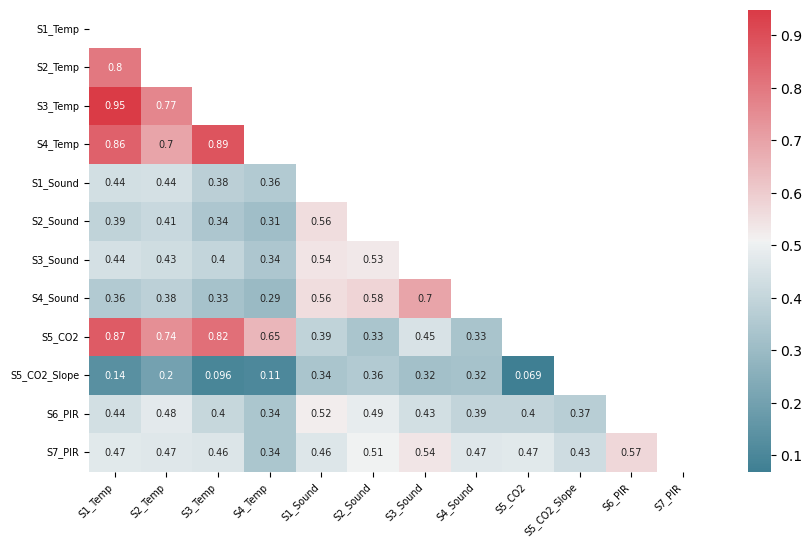

In [15]:
# Creating a correlation matrix
corr_matrix = X_wo_light.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":7},
            mask = mask
           )
plt.xticks(rotation=45, ha='right', fontsize=7) 
plt.yticks(fontsize=7) 

plt.show()

In [16]:
# Creating a function to return all variables that have good correlation coefficients

def get_correlated_variables(dataset, threshold):
    corr_columns = set() # To get unique correlated column names
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) > threshold:    # Checking the absolute value of the corr coeff
                column_name = corr_matrix.columns[i]       # Getting the name of the column
                corr_columns.add(column_name)
    return corr_columns

In [17]:
corr_features = get_correlated_variables(X_wo_light, 0.8)
corr_features

{'S3_Temp', 'S4_Temp', 'S5_CO2'}

In [18]:
# Splitting the dataset into train and test
X_train_wo_light, X_test_wo_light, y_train_wo_light, y_test_wo_light = train_test_split(X_wo_light, y_wo_light, test_size=0.2, random_state=42)

In [19]:
X_train_wo_light_corr = X_train_wo_light.drop(corr_features, axis=1)
X_train_wo_light_corr.head()

,S1_Temp,S2_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2_Slope,S6_PIR,S7_PIR
1937,25.19,25.19,0.08,0.05,0.06,0.05,0.00,0,0
4477,25.38,25.38,0.07,0.05,0.06,0.06,0.00,0,0
8550,25.56,25.63,0.07,0.05,0.05,0.08,-2.59,0,0
1346,25.50,25.50,0.07,0.04,0.07,0.06,-0.64,0,0
7296,25.38,25.38,0.07,0.05,0.06,0.10,0.00,0,0


In [20]:
X_test_wo_light_corr = X_test_wo_light.drop(corr_features, axis=1)
X_test_wo_light_corr.head()

,S1_Temp,S2_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2_Slope,S6_PIR,S7_PIR
8855,25.31,25.31,0.07,0.04,0.06,0.08,0.00,0,0
532,26.06,25.81,0.08,0.05,0.06,0.07,0.75,0,0
1155,25.69,25.75,0.07,0.05,0.06,0.06,-2.21,0,0
7769,25.19,25.19,0.08,0.06,0.06,0.09,-0.09,0,0
4922,25.19,25.19,0.06,0.05,0.06,0.06,-0.02,0,0


## 1. Using the selected variabels on the best model from part 2 - Random Forest

In [21]:
model_class_wo_light_rf = RandomForestClassifier(bootstrap= 'False', max_depth= 40, max_features= 'log2', n_estimators= 200)
model_class_wo_light_rf.fit(X_train_wo_light_corr, y_train_wo_light)

print("Accuracy on train set: ", model_class_wo_light_rf.score(X_train_wo_light_corr, y_train_wo_light))
print("Accuracy on test set: ", model_class_wo_light_rf.score(X_test_wo_light_corr, y_test_wo_light))

Accuracy on train set:  1.0
Accuracy on test set:  0.9871668311944719


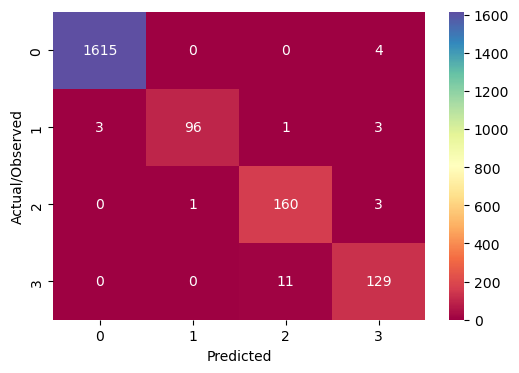

In [22]:
y_predicted_rf_corr = model_class_wo_light_rf.predict(X_test_wo_light_corr)
cm = confusion_matrix(y_test_wo_light, y_predicted_rf_corr)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [23]:
print(classification_report(y_test_wo_light, y_predicted_rf_corr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1619
           1       0.99      0.93      0.96       103
           2       0.93      0.98      0.95       164
           3       0.93      0.92      0.92       140

    accuracy                           0.99      2026
   macro avg       0.96      0.96      0.96      2026
weighted avg       0.99      0.99      0.99      2026



In [24]:
# Calculating the evaluation metrics
accuracy = accuracy_score(y_test_wo_light, y_predicted_rf_corr)
weighted_precision = precision_score(y_test_wo_light, y_predicted_rf_corr, average='weighted')
weighted_recall = recall_score(y_test_wo_light, y_predicted_rf_corr, average='weighted')
weighted_f1 = f1_score(y_test_wo_light, y_predicted_rf_corr, average='weighted')

# Creating an evaluation metrics dataframe for the model
results = pd.DataFrame([['Random Forest with Variable Selection', 
                         round(accuracy*100,2), 
                         round(weighted_precision*100,2), 
                         round(weighted_recall*100,2), 
                         round(weighted_f1*100,2)
                        ]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest with Variable Selection,98.72,98.74,98.72,98.72


In [25]:
# Saving the model with pickle

filename = 'rf_classification_model_with_VS.sav'
pickle.dump(model_class_wo_light_rf, open(filename, 'wb'))

## 2. Using the selected variabels on the best model from part 3 - Deep Learning

In [26]:
# Scaling the dataset
scaler = StandardScaler()
X_train_scaled_wo_light_corr = scaler.fit_transform(X_train_wo_light_corr)
X_test_scaled_wo_light_corr = scaler.transform(X_test_wo_light_corr)

In [27]:
model_class_wo_light_mlp = MLPClassifier(hidden_layer_sizes= (100, 100), learning_rate='constant', solver='adam')
model_class_wo_light_mlp.fit(X_train_scaled_wo_light_corr, y_train_wo_light)

print("Accuracy on train set: ", model_class_wo_light_mlp.score(X_train_scaled_wo_light_corr, y_train_wo_light))
print("Accuracy on test set: ", model_class_wo_light_mlp.score(X_test_scaled_wo_light_corr, y_test_wo_light))

Accuracy on train set:  0.9986424780945329
Accuracy on test set:  0.9763079960513327


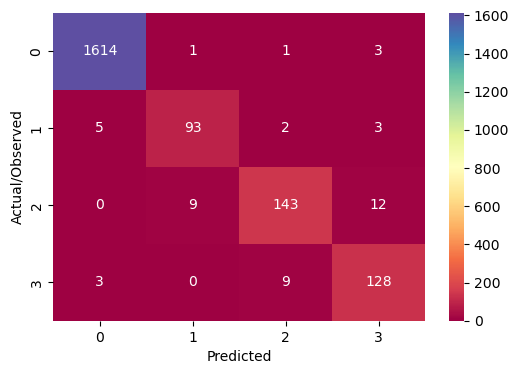

In [28]:
y_predicted_mlp_corr = model_class_wo_light_mlp.predict(X_test_scaled_wo_light_corr)
cm = confusion_matrix(y_test_wo_light, y_predicted_mlp_corr)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [29]:
print(classification_report(y_test_wo_light, y_predicted_mlp_corr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1619
           1       0.90      0.90      0.90       103
           2       0.92      0.87      0.90       164
           3       0.88      0.91      0.90       140

    accuracy                           0.98      2026
   macro avg       0.92      0.92      0.92      2026
weighted avg       0.98      0.98      0.98      2026



In [30]:
# Saving the model with pickle
filename = 'mlp_classification_model_with_VS.sav'
pickle.dump(model_class_wo_light_mlp, open(filename, 'wb'))

In [31]:
# Calculating the evaluation metrics
accuracy = accuracy_score(y_test_wo_light, y_predicted_mlp_corr)
weighted_precision = precision_score(y_test_wo_light, y_predicted_mlp_corr, average='weighted')
weighted_recall = recall_score(y_test_wo_light, y_predicted_mlp_corr, average='weighted')
weighted_f1 = f1_score(y_test_wo_light, y_predicted_mlp_corr, average='weighted')

# Creating an evaluation metrics dataframe for the model
lr_results = pd.DataFrame([['Deep Learning Model with Variable Selection', 
                         round(accuracy*100,2), 
                         round(weighted_precision*100,2), 
                         round(weighted_recall*100,2), 
                         round(weighted_f1*100,2)
                        ]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Appending the evaluation metrics into a dataframe
results = results.append(lr_results, ignore_index = True)

results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest with Variable Selection,98.72,98.74,98.72,98.72
1,Deep Learning Model with Variable Selection,97.63,97.63,97.63,97.62
